In [1]:
import logging 
from collections import Counter, namedtuple
import random 
from math import exp,ceil
import matplotlib.pyplot as plt 

In [2]:
def problem(N, seed=None):
    """Creates an instance of the problem"""

    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

Variables

In [3]:
def generate_alpha(N, sets , costs):
    alpha = dict()
    a = namedtuple("a", ["sublists","subcosts"])
    for i in range(N): 
        sublist = list()
        subcosts = list()
        for index , sub in enumerate(sets): 
            if i in sub: 
                sublist.append(index)
                subcosts.append(costs[index])
        alpha[i] = a(sublist,subcosts)
    return alpha 

In [4]:
def generate_gamma(N, sets,solution):
    gamma = list()
    
    for i in range(N): 
        n = 0

        for index , sub in enumerate(solution): 
            if (sub == 1) and (i in sets[index]) : 
                n +=1

        gamma.append(n)
    return gamma 

In [5]:
def generate_U(gamma):
    U = list()
    for index,ele in enumerate(gamma): 
        if ele == 0: 
            U.append(index)
    return U


In [6]:
def generate_beta(N, sets , costs,solution):
    gamma = list()
    
    
    for i,sub in enumerate(solution): 
        n = 0
        
        if sub == 1 :
            for index ,sub in enumerate(solution): 
                
                if  i in sets[index] : 
                    n +=1
                    
            gamma.append(n)
    return gamma 

In [7]:
N =  100 # choose between 5,10,20,100,500,1000
sets = problem(N, seed= 42)
sets = sorted(sets , key = lambda i : len(i) )
costs = list( len(s) for s  in sets)
binary = [0 for x in range(len(sets))]
alpha = generate_alpha(N,sets,costs)
beta = [list(set(sub))  for sub in sets]
print(len(sets))



427


In [8]:
def update_gamma(i,gamma):
    for j in sets[i]: 
        gamma[j]-=1

    return gamma    

In [9]:
parameters = { 5: [], 10: [], 20:[],100:[10,200,1.2],500: [10,350,2],1000: [] }
def fitness(gamma): 
    
    return sum([ ele for ele in gamma ])

def tournament(population,total ,tournament_size=10):
    
    return min(random.choices(population,[ (total - gene.fitness/total) for gene in population] , k=tournament_size), key=lambda i: i.fitness)

#def cross_over(p1,p2,child): 
#    
#    for i in range(len(binary)): 
#        if p1.genome[i] == p2.genome[i]:
#             child[i] = p1.genome[i]
#        else : 
#            prob = random.random()     
#            if prob < p2.fitness/(p1.fitness +p2.fitness):
#                 child[i] = p1.genome[i]
#            else: 
#                child[i] = p2.genome[i]
#    return child  

def cross_over(p1,p2): 
    decision=random.choice([0,1]) 
    cut = random.randint(0, len(sets)-1)
    if decision :
        return p1.genome[:cut] + p2.genome[cut:]
    else :
        return p2.genome[:cut] + p1.genome[cut:]
    



def mutation(child):
       
        indexes = random.choices(list(range(len(sets))), k =50)
        for i in indexes:
            child[i] = 1 - child[i]
        return child

In [10]:
Individual = namedtuple("Individual", ["genome", "fitness"])
def generate_population(size):
    population = list()
    
    for _ in range(size): 
        S= list()
        subsets = list()
        solution =  [0 for _ in range(len(sets))]
        for i in range(N): 
            j = random.choice(alpha[i].sublists)
            solution[j] = 1
            subsets.append(j)
        K = len(subsets)
       
        gamma = generate_gamma(N,sets,solution)
        while K != 0: 
            
            j = random.choice(subsets)
            threshold = len(sets[j])
            rep = 0
            for i in sets[j]:
                if gamma[i] >=2:
                    rep +=1
            if rep == threshold: 
                solution[j] = 0 
                gamma = update_gamma(j,gamma)
            K -= 1

        population.append(Individual(solution, fitness(gamma)))    
    return population
            

In [11]:

def turn_feasable(child,sets,N):
    def intersection(lst1, lst2):
        inter = list(set(lst1) & set(lst2))
        if inter !=0: 
            return len(inter)
        else: 
            return 0.000001
    gamma = generate_gamma(N,sets,child)
    U = generate_U(gamma)
    
    while len(U)!=0: 
        indexes =  alpha[U[0]].sublists
        j = sorted(indexes , key = lambda i : len(sets[i])/intersection(U,sets[i]))[0]
        child[j] = 1
        U = list(set(U) - set(sets[j]))
    S  = [i for i, val in enumerate(child) if val]
    gamma = generate_gamma(N,sets,child)
    for j in reversed(S):
        
        threshold = len(sets[j])
        rep = 0
        for i in sets[j]:
            if gamma[i] >=2:
                rep +=1
        if rep == threshold: 
            child[j] = 0 
            gamma = update_gamma(j,gamma)
    
    return child , gamma


In [12]:
POPULATION_SIZE = 100
population = generate_population(POPULATION_SIZE)
fitness_log = [(0, i.fitness) for i in population]
NUM_GENERATIONS = 1000
OFFSPRING_SIZE = 30

for g in range(NUM_GENERATIONS):
    offspring = list()
    for i in range(OFFSPRING_SIZE):

        tot_fitness = sum([ gene.fitness for gene in population])
        p1 = tournament(population,tot_fitness)
        p2 = tournament(population, tot_fitness)
        child = cross_over(p1, p2)
        child = mutation(child)
        child,gamma = turn_feasable(child,sets,N)
        f = fitness(gamma)
        fitness_log.append((g + 1, f))
        offspring.append(Individual(child, f))
    print(g)
    population += offspring
    population = sorted(population, key=lambda i: -i.fitness, reverse=True)[:POPULATION_SIZE]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Individual(genome=[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [15]:
print(population[0])
cost  =    sum([ len(sets[index]) for  index,val in enumerate(population[0].genome) if val==1 ])
print(cost)

Individual(genome=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [44]:
a = set()
for i,ele in enumerate(solution[0]): 
   if ele : 
    a |= set(sets[i])
print(a)   

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}


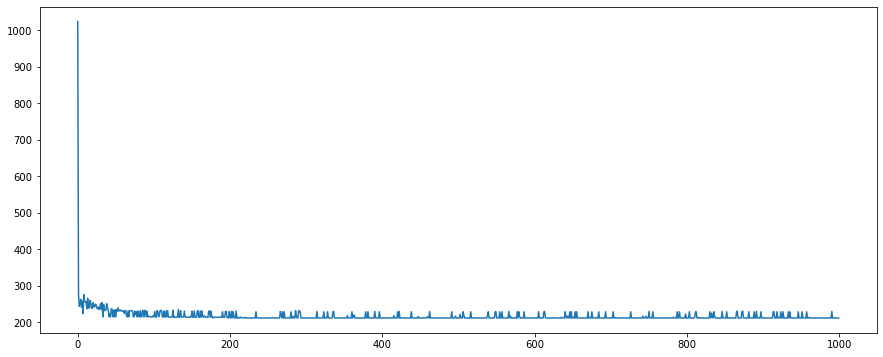

In [61]:


off_line = [max(f[1] for f in fitness_log if f[0] == x) / (x + 1) for x in range(NUM_GENERATIONS)]
on_line = [max(f[1] for f in fitness_log if f[0] <= x) / (x + 1) for x in range(NUM_GENERATIONS)]
gen_best = [min(f[1] for f in fitness_log if f[0] == x) for x in range(NUM_GENERATIONS)]

plt.figure(figsize=(15, 6))
#plt.scatter([x for x, _ in fitness_log], [y for _, y in fitness_log], marker=".")
plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)])
#plt.plot([x for x, _ in enumerate(on_line)], [y for _, y in enumerate(on_line)])
#plt.plot([x for x, _ in enumerate(off_line)], [y for _, y in enumerate(off_line)])
